In [1]:
import random
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

# Задание 5. Глубокая сеть

Опишите сверточную архитектуру для классификации CIFAR10. Доведите в ней число общее число слоев минимум до 9  (под слоем понимается `nn.Conv2d` или `nn.Linear`). Используйте правильную инициализацию весов, [BatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html?highlight=batchnorm#torch.nn.BatchNorm2d) между слоями и другие техники улучшения сходимости обсуждавшиеся в лекции.

* Обучитете модель на датасете CIFAR10.
* Отладку рекомендуем проводить на фрагменте датасета.
* Оцените точность классификации на полном датасете.
* Сравните точность с результатами полученными на прошлом занятии.

Совет: не делайте больше 2-3 линейных слоев.

Загрузим CIFAR10

In [2]:
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            [0.4914, 0.4822, 0.4465], [0.2470, 0.2434, 0.2615]
        ),
    ]
)

cifar = CIFAR10(root="CIFAR10", train=True, download=True, transform=transform)
cifat_test = CIFAR10(root="CIFAR10", train=False, download=True, transform=transform)

(
    train_set_cifar,
    val_set_cifar
) = torch.utils.data.random_split(cifar, [45000, 5000])

batch_size = 64

train_loader = DataLoader(
    train_set_cifar, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader = DataLoader(
    val_set_cifar, batch_size=batch_size, shuffle=False, num_workers=2
)
test_loader = DataLoader(
    cifat_test, batch_size=batch_size, shuffle=False, num_workers=2
)

100%|██████████| 170498071/170498071 [00:01<00:00, 86307991.13it/s]


Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10
Files already downloaded and verified


In [29]:
class CifarCNN(nn.Module):
    def __init__(self):
        super().__init__()
        #self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Conv2d(
            in_channels=3, out_channels=6, kernel_size=5, padding=1
            ),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=1
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=5, padding=1
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=5, padding=1
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=5, padding=1
            ),
            nn.BatchNorm2d(128),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=3, padding=1
            ),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.Dropout(p=0.3),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 10),
            )

    def forward(self, x):
        # Your code here
        scores = self.layers_stack(x)
        return scores

In [19]:
from IPython.display import clear_output
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np


class ProgressPlotter:
    """
    Groups contain a list of variables to output, like ["loss", "accuracy"]
    If group is None all variables will be plotted

    Title is expariment_id like "Relu_Adam_lr003"
    All new collected data binded to current title
    """

    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
            if len(data) > 1:
                ax.legend(loc="upper right")
            if history_len < 50:
                ax.set_xlabel("step")
                ax.set_xticks(np.arange(history_len))
                ax.set_xticklabels(np.arange(history_len))

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(48 // n_groups, 3))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

In [4]:
# compute on cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch

def get_correct_count(pred, labels):
  _, predicted = torch.max(pred.data, 1)
  return (predicted.cpu() == labels.cpu()).sum().item()

@torch.inference_mode()
def calculate_accuracy(model, data_loader, criterion, device):
    correct, total = 0, 0
    loss = 0
    for batch in data_loader:
        imgs, labels = batch
        pred = model(imgs.to(device))
        loss += criterion(pred, labels.to(device))
        correct += get_correct_count(pred, labels.to(device))
        total += labels.size(0)

    return correct / total , loss.item() / len(data_loader)

def train_epoch(model, optimizer, criterion, train_loader):
    loss_history = []
    for batch in train_loader:
        optimizer.zero_grad()
        x_train, y_train = batch  # parse data
        x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
        y_pred = model(x_train)  # get predictions
        loss = criterion(y_pred, y_train)  # compute loss
        loss_history.append(loss.cpu().detach().item())  # write loss to log
        loss.backward()
        optimizer.step()
    return loss_history

In [5]:
def validate(model, criterion, val_loader):
    cumloss = 0
    loss_history = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch  # parse data
            x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
            y_pred = model(x_train)  # get predictions
            loss = criterion(y_pred, y_train)  # compute loss
            loss_history.append(loss.cpu().detach().item())  # write loss to log
            cumloss += loss
    return cumloss / len(val_loader), loss_history  # mean loss and history

In [6]:
from tqdm.notebook import tqdm


def train_model(model, optimizer, model_name=None, num_epochs=20):
    criterion = nn.CrossEntropyLoss().to(device)

    train_history = {}
    train_history["model_name"] = model_name
    train_history["epoсhs"] = num_epochs
    train_history["loss_on_train"] = []
    train_history["loss_on_test"] = []
    train_history["accuracy"] = []

    for epoch in tqdm(range(num_epochs)):
        loss_on_train = train_epoch(model, optimizer, criterion, train_loader)
        _, loss_on_test = validate(model, criterion, test_loader)
        train_history["loss_on_train"].extend(loss_on_train)
        train_history["loss_on_test"].extend(loss_on_test)
        accuracy, loss_val = calculate_accuracy(model, val_loader, criterion, device)
        train_history["accuracy"].append(accuracy)
    return train_history

In [35]:
model_cifar = CifarCNN().to(device)
def init_weights_kaiming(m):
  if type(m) == nn.Conv2d or type(m) == nn.Linear:
    torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
model_cifar.apply(init_weights_kaiming)
optimizer = optim.Adam(model_cifar.parameters(), lr=1e-3)
Adam_model_cifar = train_model(model_cifar, optimizer, model_name="Adam_model_cifar")

  0%|          | 0/20 [00:00<?, ?it/s]

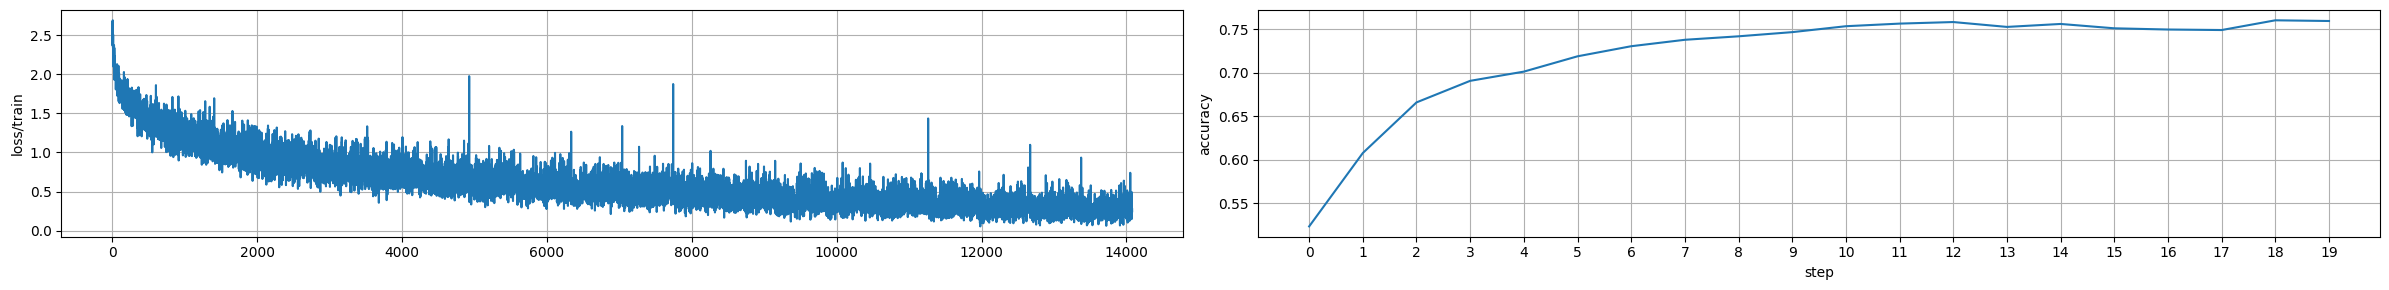

In [40]:
pplotter = ProgressPlotter()
pplotter.set_title('SGD_momentum')
for i in range(len(Adam_model_cifar['loss_on_train'])):
    pplotter.add_scalar('loss/train', Adam_model_cifar['loss_on_train'][i])
for i in range(len(Adam_model_cifar['accuracy'])):
    pplotter.add_scalar('accuracy', Adam_model_cifar['accuracy'][i])
pplotter.display(['loss/train', 'accuracy'])

In [42]:
print('Accuracy, loss for test')
calculate_accuracy(model_cifar, test_loader, nn.CrossEntropyLoss().to(device), device)

Accuracy, loss for test


(0.7518, 0.9016608948920183)

## Формат результата

* Графики loss и accuracy при обучении


<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/Exercises/EX07/result_1_task_5_ex07_v1.png" width="1200" >

* Занчение accuracy на тесте должно составить не менее 0.72




**Вывод: добавление большего количества слоев, использование инициализации весов и dropout повышает качество модели. Правда, большое число сверточных слоев, как я понял, утяжеляет модель по памяти, и пришлось понавтыкать побольше слоев пулинга.**